In [4]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace
import datetime as dt

from numpy import genfromtxt

import sys
sys.path.append('../../models')
from models import firstordermodel, secondordermodel, thirdordermodel

sys.path.append('../')
from tools import stochasticSimulation, derive_regimes, discrete_ivp_solver, \
                    smooth_dap, sol_ivp_wrapper, sol_ivp_wrapper_discrete,\
                    smooth_regime, cost, sigmoid,\
                    simulate_MPC, mergeSwitchCont,\
                    build_initial_ipopt_object,\
                    consMatrix



%load_ext autoreload
%autoreload 2

# PATHS
FIGS = '/Users/madsobdrup/Dropbox/Skole/DTU/Studie/MASTER/THESIS/FIGS'

# Switching time optimization modules
import switching_times_1st as st1
import switching_times_1st_rk as st1_rk
import switching_times_2nd as st2

import lxml

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

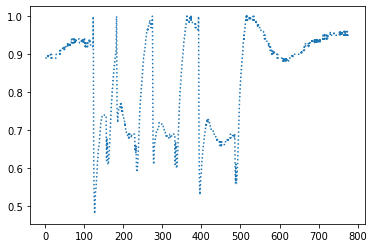

In [5]:
data_full = pd.read_csv('../../data/high_tc_20190913.csv', sep = ';', encoding="latin1", header = 0, index_col = 0)


data_full.index = pd.to_datetime(data_full.index, format='%Y-%m-%d %H:%M:%S')
data = data_full.filter(['A40_A_CompCap'], axis=1)
data['A40_A_CompCap'] = data['A40_A_CompCap']/100
data['t'] = 60 * data_full.index.hour + data_full.index.minute + 1/60 * data_full.index.second
data['t'] = data['t'] - data['t'][0]

k_baseline = 12400.
k_MELT = 250.
k_IDLE = 9.


plt.plot(data['t'], data['A40_A_CompCap'], ls = 'dotted')

## First order model

In [6]:
# Define model
lambda_MELT = 0.00183*60
mu_MELT = 66.92400 
lambda_IDLE = 0.00085*60
mu_IDLE = 94.89100
sigma = 0.28130
R = 1.96580
pars = np.array([lambda_MELT, mu_MELT, lambda_IDLE, mu_IDLE, sigma, R])
m1 = firstordermodel(pars)

tf = 60 * 24
x0 = np.array(90)


# Extract switch solution from C++
switches = genfromtxt('../results/optimal_pars.csv', delimiter=',')
tau_MELT_all, tau_IDLE_all  = derive_regimes(switches,tf,1)
tau_MELT, tau_IDLE = derive_regimes(switches,tf,0)
switches = np.concatenate((tau_MELT, tau_IDLE))
switches[-1 ] += 0.1 # To avoid duplicate

# Draw random switches in the format [tau_melt, tau_idle]
#np.random.seed(1234)
#n_s = 5
#switch = np.sort(np.random.uniform(0,tf,2*n_s))
#switch = np.concatenate(derive_regimes(switch,0,0))
#switch

### With test switches from data

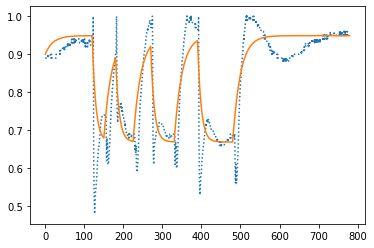

In [7]:
tf = data['t'][-1]
switches_data = pd.to_datetime(["2019-09-17 13:00:00",
                 "2019-09-17 13:30:00",
                 "2019-09-17 14:00:00",
                 "2019-09-17 14:45:00",
                 "2019-09-17 15:30:00",
                 "2019-09-17 16:30:00",
                 "2019-09-17 17:30:00",
                 "2019-09-17 19:00:00"])
switches_data = (60 * (switches_data.hour - data_full.index.hour[0]) + switches_data.minute - data_full.index.minute[0]).astype(int)
tau_MELT_all_data, tau_IDLE_all_data  = derive_regimes(switches_data,tf,1)
switches_data = np.concatenate(derive_regimes(switches_data,0,0))
x0 = np.array([90.])
T, X, Z = sol_ivp_wrapper_discrete(m1,x0,switches_data,tf,data['t'])
plt.plot(data['t'], data['A40_A_CompCap'], ls = 'dotted')
plt.plot(T, Z[0])

## Second order model

In [8]:
# Define model
mu_IDLE = 957.10401120
mu_MELT = 700.74438030
omega_IDLE = 0.05220237
omega_MELT = 0.30504764
xi_IDLE = 0.18367929
xi_MELT = 0.50240445 
slope = 0.00778941
offset = 599.12794983
logsigma = np.array([-0.44650699, 2.53627662])
logR = -10.86389382

pars = np.array([mu_IDLE, mu_MELT, omega_IDLE, omega_MELT, xi_IDLE, xi_MELT, slope, offset, logsigma, logR])
m2 = secondordermodel(pars)

### With test switches from data

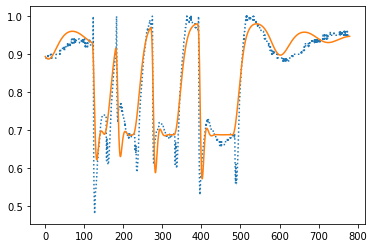

In [9]:
tf = data['t'][-1]
switches_data = pd.to_datetime(["2019-09-17 13:00:00",
                 "2019-09-17 13:30:00",
                 "2019-09-17 14:00:00",
                 "2019-09-17 14:45:00",
                 "2019-09-17 15:30:00",
                 "2019-09-17 16:30:00",
                 "2019-09-17 17:30:00",
                 "2019-09-17 19:00:00"])
switches_data = (60 * (switches_data.hour - data_full.index.hour[0]) + switches_data.minute - data_full.index.minute[0]).astype(int)
tau_MELT_all_data, tau_IDLE_all_data  = derive_regimes(switches_data,tf,1)
switches_data = np.concatenate(derive_regimes(switches_data,0,0))
x0 = np.array([2.17082264, 873.03730756])
T, X, Z = sol_ivp_wrapper_discrete(m2,x0,switches_data,tf,data['t'])
plt.plot(data['t'], data['A40_A_CompCap'], ls = 'dotted')
plt.plot(T, Z[0])

# Third order model

In [13]:
# Define model
mu_IDLE = 0.929224978
mu_MELT = 0.683920449 
a0_IDLE = 0.023590616
a0_MELT = 0.019370754
a1_IDLE = 0.867249723  
a1_MELT = 0.151822292
a2_IDLE = 46.261177791   
a2_MELT = 1.206710500
slow = 0.318488737 
logsigma = np.array([-5.110433517, -18.493395485,  -5.116712113])
logR = -8.444535962



pars = np.array([mu_IDLE, mu_MELT, a0_IDLE, a0_MELT, a1_IDLE, a1_MELT, a2_IDLE, a2_MELT, slow, logsigma, logR])
m3 = thirdordermodel(pars)

In [ ]:
tf = data['t'][-1]
switches_data = pd.to_datetime(["2019-09-17 13:00:00",
                 "2019-09-17 13:30:00",
                 "2019-09-17 14:00:00",
                 "2019-09-17 14:45:00",
                 "2019-09-17 15:30:00",
                 "2019-09-17 16:30:00",
                 "2019-09-17 17:30:00",
                 "2019-09-17 19:00:00"])
switches_data = (60 * (switches_data.hour - data_full.index.hour[0]) + switches_data.minute - data_full.index.minute[0]).astype(int)
tau_MELT_all_data, tau_IDLE_all_data  = derive_regimes(switches_data,tf,1)
switches_data = np.concatenate(derive_regimes(switches_data,0,0))
x0 = np.array([0.894357214,   0.007045742,  -0.360118853])
T, X, Z = sol_ivp_wrapper_discrete(m3,x0,switches_data,tf,data['t'])
plt.plot(data['t'], data['A40_A_CompCap'], ls = 'dotted')
plt.plot(T, Z[0])

# Prices

In [10]:
regulation = pd.read_csv('../../data/realtimemarket.csv',header=0, index_col=0,skiprows = 0)
regulation = regulation.loc[regulation['PriceArea'] == 'DK1']
regulation = regulation[{'BalancingPowerPriceDownEUR','BalancingPowerPriceUpEUR'}]
regulation.index = pd.to_datetime(regulation.index)
regulation = regulation.reindex(index=regulation.index[::-1])

In [11]:
spot = pd.read_csv('../../data/elspotprices.csv',header=0, index_col=0,skiprows = 0)
spot = spot.loc[spot['PriceArea'] == 'DK1']
spot = spot[{'SpotPriceEUR'}]
spot.index = pd.to_datetime(spot.index)
spot = spot.reindex(index=spot.index[::-1])

In [12]:
prices = pd.concat([spot, regulation], axis=1, join='inner')
prices.columns = ['spot', 'up', 'down']
#prices = prices * 1e-6


# Make correct round off
num_deci = 2
prices_og = prices
prices = np.round(np.round(prices_og * 10**num_deci,num_deci) / 10**num_deci,num_deci) #= np.round(prices,3)

In [13]:
np.mean((prices['spot'] != prices['up']) & (prices['spot'] != prices['down']))
1 - np.mean(np.minimum(np.abs(prices['spot'] - prices['up']),np.abs(prices['spot'] - prices['down'])) > 0.1)

0.9988961435483114

In [14]:
prices_ambg = prices.loc[(prices['spot'] != prices['up']) & (prices['spot'] != prices['down'])]
prices[np.minimum(np.abs(prices['spot'] - prices['up']),np.abs(prices['spot'] - prices['down'])) > 0.1]

#plt.hist(min_diff)


,spot,up,down
HourUTC,,,
2017-10-29 00:00:00,-24.62,-22.83,-22.83
2017-10-29 01:00:00,-24.62,-22.83,-22.83
2018-06-25 22:00:00,43.02,42.92,42.92
2018-06-25 23:00:00,40.79,40.69,45.89
2018-06-26 00:00:00,41.28,41.18,45.81
2018-06-26 01:00:00,41.56,41.46,44.73
2018-06-26 02:00:00,41.15,34.73,41.05
2018-06-26 03:00:00,41.96,34.73,41.86
2018-06-26 04:00:00,48.94,40.60,48.82


In [15]:
# Derive markets
tol = 1e-2

prices['market_spot'] = 0
prices['market_down'] = 0
prices['market_up'] = 0

# When both up and down is less than tol away from the spot price
prices.loc[(np.abs(np.round(prices['spot'] - prices['down'],2)) <= tol) & (np.abs(np.round(prices['spot'] - prices['up'],2)) <= tol),'market_spot'] = 1

# When both are different, but even the smallest is bigger than 0.1 we have an error. Put it to spot market
prices.loc[np.minimum(np.abs(prices['spot'] - prices['up']),np.abs(prices['spot'] - prices['down'])) > 0.1,'market_spot'] = 1


prices.loc[(prices['market_spot'] != 1) & (np.abs(np.round(prices['spot'] - prices['down'],2)) > np.abs(np.round(prices['spot'] - prices['up'],2))),'market_down'] = 1
prices.loc[(prices['market_spot'] != 1) & (np.abs(np.round(prices['spot'] - prices['down'],2)) <= np.abs(np.round(prices['spot'] - prices['up'],2))),'market_up'] = 1


frac_down = np.mean(prices['market_down'])
frac_spot = np.mean(prices['market_spot'])
frac_up = np.mean(prices['market_up'])

[frac_down, frac_spot, frac_up], np.sum([frac_down, frac_spot, frac_up])




([0.2864390060594673, 0.2907839729437738, 0.4227770209967589], 1.0)

### Spot prices

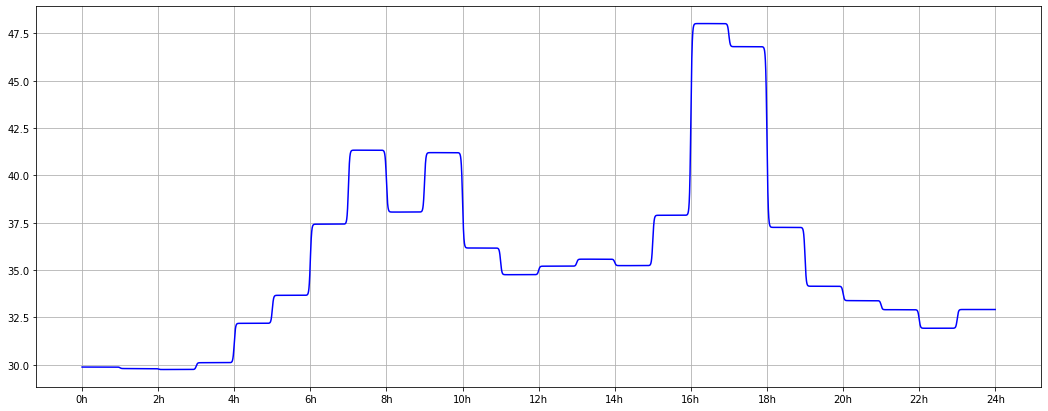

In [16]:
prices_plot = prices['2018-02-02  00:00:00':'2018-02-02  23:00:00']
T_price = 0.1 * np.arange(1,prices_plot.shape[0] * 60/0.1)
day_skip = 2
fig = plt.figure(figsize=(18,7))    
ax = fig.add_subplot(111)
ax.plot(T_price,smooth_dap(T_price,prices_plot['spot']),color='b')
ax.set_xticks(np.arange(0,prices_plot['spot'].size+1,day_skip)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,prices_plot['spot'].size+1,day_skip) * 60.])
ax.grid()
plt.savefig(FIGS + '/control/example_dap.pdf',format='pdf')

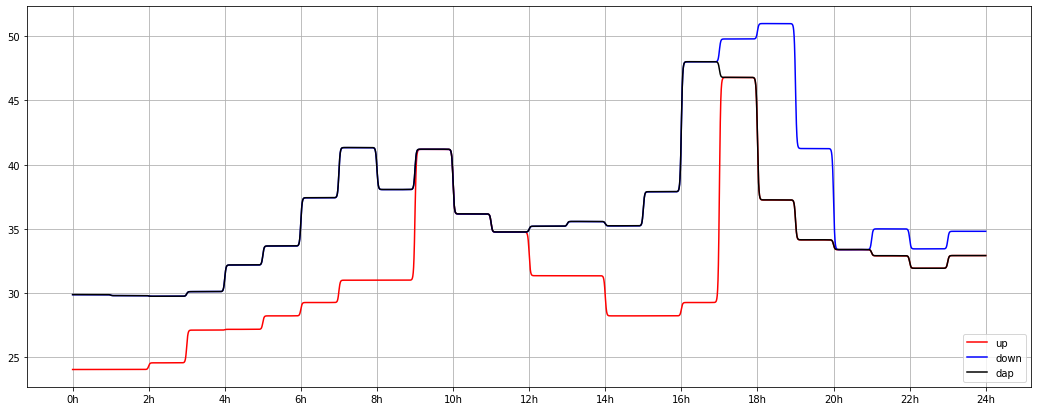

In [17]:
fig = plt.figure(figsize=(18,7))    
ax = fig.add_subplot(111)
ax.plot(T_price,smooth_dap(T_price,prices_plot['up']),color='red',label='up')
ax.plot(T_price,smooth_dap(T_price,prices_plot['down']),color='blue',label='down')
ax.plot(T_price,smooth_dap(T_price,prices_plot['spot']),color='black',label='dap')
ax.set_xticks(np.arange(0,prices_plot['spot'].size+1,day_skip)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,prices_plot['spot'].size+1,day_skip) * 60.])
ax.grid()
ax.legend(loc='lower right')
plt.savefig(FIGS + '/control/example_regulation_price.pdf',format='pdf')

### Spot prices - bad

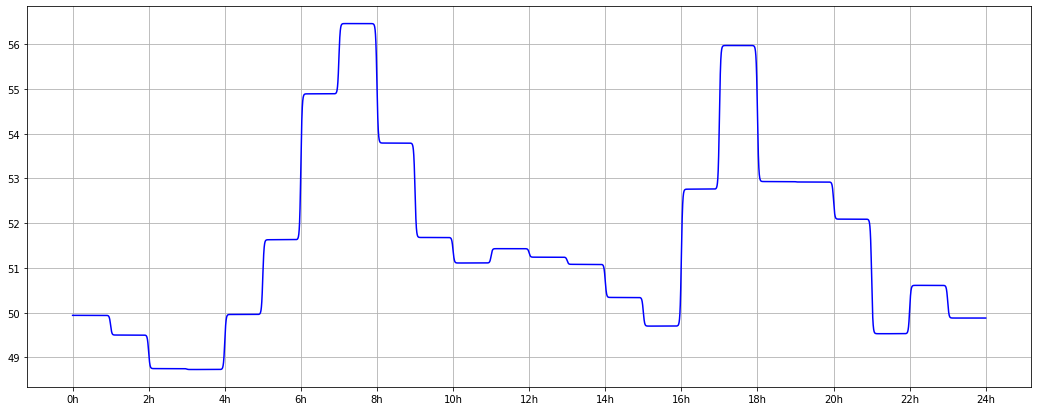

In [18]:
prices_plot_bad = prices['2018-08-04  00:00:00':'2018-08-04  23:00:00']
T_price = 0.1 * np.arange(1,prices_plot_bad.shape[0] * 60/0.1)
day_skip = 2
fig = plt.figure(figsize=(18,7))    
ax = fig.add_subplot(111)
ax.plot(T_price,smooth_dap(T_price,prices_plot_bad['spot']),color='b')
ax.set_xticks(np.arange(0,prices_plot_bad['spot'].size+1,day_skip)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,prices_plot_bad['spot'].size+1,day_skip) * 60.])
ax.grid()
plt.savefig(FIGS + '/control/example_dap_wrong.pdf',format='pdf')

### RK Prices - bad

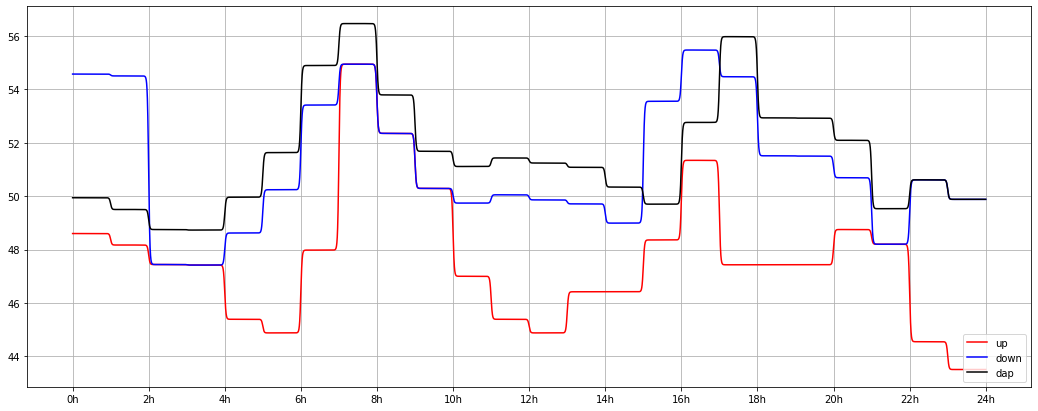

In [19]:
fig = plt.figure(figsize=(18,7))    
ax = fig.add_subplot(111)
ax.plot(T_price,smooth_dap(T_price,prices_plot_bad['up']),color='red',label='up')
ax.plot(T_price,smooth_dap(T_price,prices_plot_bad['down']),color='blue',label='down')
ax.plot(T_price,smooth_dap(T_price,prices_plot_bad['spot']),color='black',label='dap')
ax.set_xticks(np.arange(0,prices_plot_bad['spot'].size+1,day_skip)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,prices_plot_bad['spot'].size+1,day_skip) * 60.])
ax.grid()
ax.legend(loc='lower right')
plt.savefig(FIGS + '/control/example_regulation_price_bad.pdf',format='pdf')

In [20]:
mean_down = np.mean(prices.loc[prices['market_down'] == 1,'spot'] - prices.loc[prices['market_down'] == 1,'down'])
mean_up = np.mean(prices.loc[prices['market_up'] == 1,'up'] - prices.loc[prices['market_up'] == 1,'spot'])
mean_down, mean_up

(-9.911121679239095, -8.236418532303762)

In [21]:
prices

,spot,up,down,market_spot,market_down,market_up
HourUTC,,,,,,
2015-05-09 19:00:00,20.95,20.95,25.60,0,1,0
2015-05-09 20:00:00,20.99,20.99,26.27,0,1,0
2015-05-09 21:00:00,19.03,19.03,25.00,0,1,0
2015-05-09 22:00:00,8.10,8.10,18.50,0,1,0
2015-05-09 23:00:00,10.32,10.32,18.50,0,1,0
...,...,...,...,...,...,...
2020-03-17 18:00:00,31.09,31.09,31.09,1,0,0
2020-03-17 19:00:00,14.06,14.06,14.06,1,0,0
2020-03-17 20:00:00,7.49,4.50,7.49,0,0,1


## Model simulation

In [26]:
# Simulate from model
t0 = 0.
tf = 60.*24.
dt = 0.01
model = m1; x0 = np.array([90])
model = m2; x0 = np.array([2.17082264, 873.03730756])
model = m3; x0 = np.array([0.894357,    0.007046,   -0.360119])


np.random.seed(144257)
T, X, Y, Z = stochasticSimulation(model,switches,x0,tf,dt)
T_ode, X_ode, Z_ode = sol_ivp_wrapper(model,x0,switches,tf,T)

1440.0
0.01


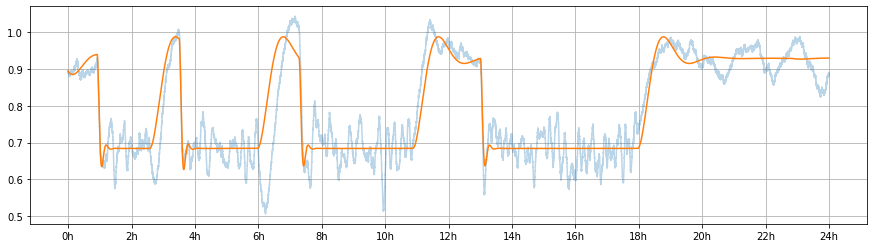

In [27]:
fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot(111)

ax.plot(T,Z[0],alpha = 0.3)
ax.plot(T_ode,Z_ode[0])
ax.set_xticks(np.arange(0,24+1,2)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,24+1,2) * 60.])
ax.grid()

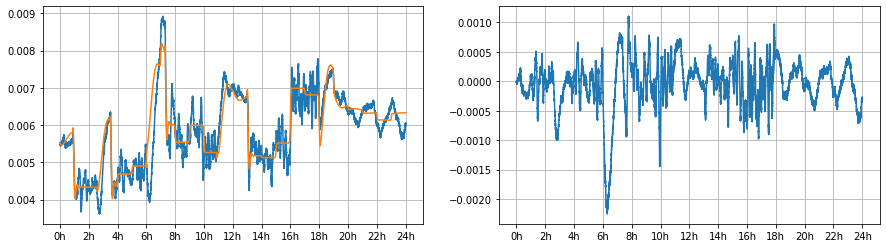

In [31]:
dap = prices_plot['spot'] * 1e-6
cost_true, cost_acc_true = cost(Z[0],T,switches,dap,k_baseline,k_MELT,k_IDLE)
cost_exp, cost_acc_exp = cost(Z_ode[0],T_ode,switches,dap,k_baseline,k_MELT,k_IDLE)

fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot(121)
ax.plot(T,cost_true)
ax.plot(T,cost_exp)
ax.set_xticks(np.arange(0,dap.size+1,2)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,dap.size+1,2) * 60.])

ax.grid()

ax = fig.add_subplot(122)
plt.plot(T,cost_true - cost_exp)
ax.set_xticks(np.arange(0,dap.size+1,2)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,dap.size+1,2) * 60.])
ax.grid()

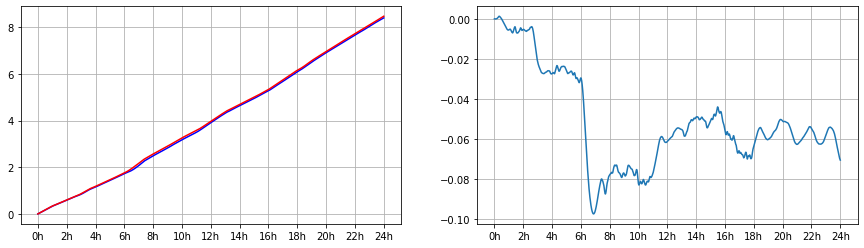

In [32]:
fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot(121)
ax.plot(T[1:],cost_acc_true, color = 'blue')
ax.plot(T_ode[1:],cost_acc_exp, color = 'red')
ax.set_xticks(np.arange(0,dap.size+1,2)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,dap.size+1,2) * 60.])

ax.grid()

ax = fig.add_subplot(122)
plt.plot(T[1:],cost_acc_true - cost_acc_exp)
ax.set_xticks(np.arange(0,dap.size+1,2)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,dap.size+1,2) * 60.])
ax.grid()

# Loop : Plan 2 days, simulate 1 day

In [2]:
nswitches = 10
tf_sim = 60 * 24
tf_ph = 60 * 48

In [3]:
# ------ Define models -------

# "True" model
# -------------
#system_true = m1; x0_true = np.array([90])
system_true = m2; x0_true = np.array([2.6659426, 899.8884004])
# -------------

# Expectation model
# -------------
system_model = m1; x0_model = np.array([90])
#system_model = m2; x0_model = np.array([2.6659426, 899.8884004])
# -------------

# Optimization object
# -------------
tank = st1_rk.plant(); tank_pars = m1.drift_pars
#tank = st2.plant(), tank_pars = m1.drift_pars
# -------------

# Define optimization parameters
max_melt = 16. * 60.
dt_opt = 0.1
n_s = 10
t0 = 0.
tank = build_initial_ipopt_object(tank, tank_pars, dt_opt, k_baseline, k_MELT, k_IDLE, t0, tf_ph, max_melt, n_s)

NameError: name 'm2' is not defined

In [38]:
tank.get_p_optimize()

array([ 201.6,  457.6,  713.6,  969.6, 1225.6, 1481.6, 1737.6, 1993.6,
       2249.6, 2505.6,  288. ,  544. ,  800. , 1056. , 1312. , 1568. ,
       1824. , 2080. , 2336. , 2592. ])

In [39]:
prices

,spot,up,down,market_spot,market_down,market_up
HourUTC,,,,,,
2015-05-09 19:00:00,20.95,20.95,25.60,0,1,0
2015-05-09 20:00:00,20.99,20.99,26.27,0,1,0
2015-05-09 21:00:00,19.03,19.03,25.00,0,1,0
2015-05-09 22:00:00,8.10,8.10,18.50,0,1,0
2015-05-09 23:00:00,10.32,10.32,18.50,0,1,0
...,...,...,...,...,...,...
2020-03-17 18:00:00,31.09,31.09,31.09,1,0,0
2020-03-17 19:00:00,14.06,14.06,14.06,1,0,0
2020-03-17 20:00:00,7.49,4.50,7.49,0,0,1


In [52]:
# Simulation options
start_date = '2015-05-09 19:00:00'
n_days = 2
dt_sim = 0.01
seed = 1233
save_to_file = 1

In [53]:
history = simulate_MPC(system_true,system_model,tank,
                 x0_true,x0_model,n_days,prices,k,k_MELT,k_IDLE,dt,
                 start_date,seed,save_to_file)


10
  ----- Simulating day 0 ----  
 ... Optimizing
 ... Simulating true process
1440
0.01
 ... Simulating model process
  ----- Simulating day 1 ----  
 ... Optimizing
 ... Simulating true process
1440
0.01
 ... Simulating model process


In [54]:
history['SWITCHES'][0]

array([ 201.57830642,  457.57508422,  713.57340385,  969.54868654,
       1225.54485217, 1481.53254162, 1737.55357995, 1993.53245601,
       2249.53658412, 2505.53874571,  288.0310983 ,  544.02437382,
        800.00757544, 1056.05072366, 1312.06164426, 1568.06193964,
       1824.05137281, 2080.06414912, 2336.06202305, 2592.06074074])

In [59]:
day

2

array([1.92383139e-05, 1.05314804e-04])

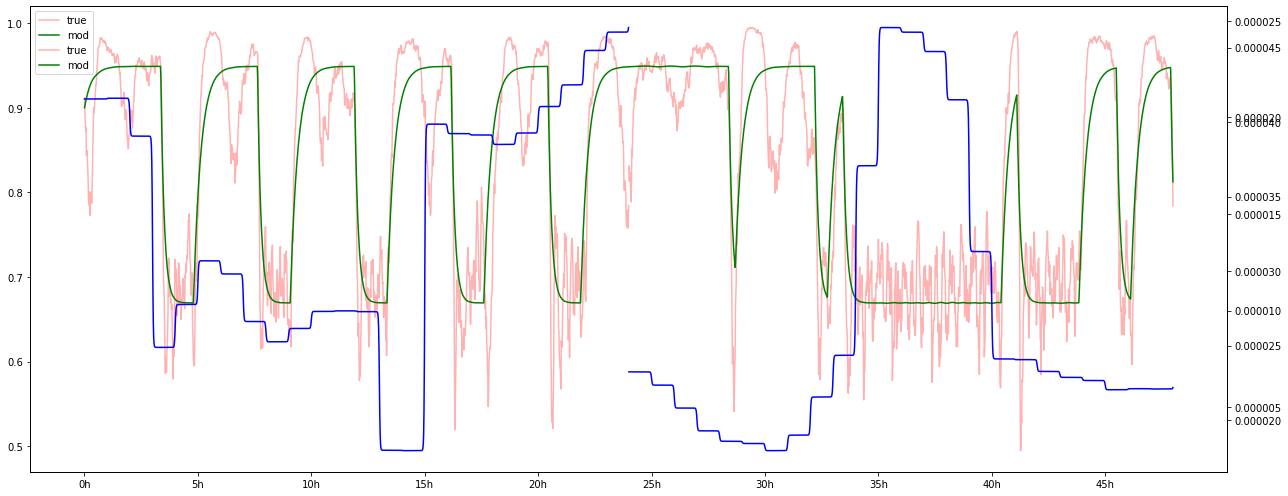

In [71]:
day = 0
fig = plt.figure(figsize=(18,7))   
ax1 = fig.add_subplot(111)
for day in range(2):
    ax1.plot(history['T'][0] + day * 60*24,history['Z_true'][day][0],color = 'r',label= "true",alpha = 0.3)
    ax1.plot(history['T'][0]  + day * 60*24 ,history['Z_model'][day][0],color = 'green', label='mod',alpha = 1)
    
    ax2 = ax1.twinx()
    #ax2.set_ylabel('tmp', color='r')
    #ax2.tick_params('y', [])
    ax2.plot(history['T'][0]+ day * 60*24,smooth_dap(history['T'][0],history['PRICES'][day]),color='b')
    #plt.axvline(1440, 0, 1, label='pyplot vertical line')
    #ax.set_xticks(np.arange(0,dap.size+1,2)*60.)
    #ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,dap.size+1,2) * 60.])
    #plt.plot(day * 24 * 60 + history['SWITCHES'][day][:n_s],np.array([0 for i in range(n_s)]),'bo',label = 'MELT',alpha = 0.5)
    #plt.plot(day * 24 * 60 + history['SWITCHES'][day][n_s:],np.array([0 for i in range(n_s)]),'r*',label = 'IDLE',alpha = 0.5)

#ax2.plot(24 * 60 * np.arange(1,3), history['price_true'])    
ax1.set_xticks(np.arange(0,history['PRICES'].size/2+1,5)*60.)
ax1.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,4 * history['PRICES'].size/2+1,5) * 60.])
ax1.legend()
#ax1.grid()
#ax1.set_ylim(-0.5,3)
#ax2.set_ylim(-0.5,3)
fig.tight_layout()


In [66]:
history['T'][0] + day * 60*24

array([1440.01, 1441.01, 1442.01, ..., 2877.01, 2878.01, 2879.01])

In [ ]:
history['PRICES'].size

In [ ]:
history['price_true']

# Example of an iteration

In [42]:
day = 0
idx_offset = np.where(prices.index == start_date)[0][0]
start_model = x0_model

In [74]:
idx = np.arange(48) + day * 48 + idx_offset
future_days = np.array(prices.index[idx])
#future_hours = np.array(prices['Hours'][idx])
future_price = np.array(prices['spot'][idx]).astype(np.float) * 1/1000000


# ---------------------------
# Compute optimal switches over 2 days
# ---------------------------

# -- Set new optimization object

# Initial state of the system
tank.set_x0(np.append(start_model,0)) 

# Update prices
p_dynamic = tank.get_p_dynamic()
for k in range(0, 48):
    p_dynamic[k] = future_price[k]
tank.set_p_dynamic(p_dynamic)




opt = tank.get_p_optimize()
# Solve
tank.solve()

In [44]:
init_switch = tank.get_p_optimize()
opt_switch = tank.get_p_optimize_ipopt()
init_switch - opt_switch

array([ 0.02169358,  0.02491578,  0.02659615,  0.05131346,  0.05514783,
        0.06745838,  0.04642005,  0.06754399,  0.06341588,  0.06125429,
       -0.0310983 , -0.02437382, -0.00757544, -0.05072366, -0.06164426,
       -0.06193964, -0.05137281, -0.06414912, -0.06202305, -0.06074074])

In [45]:
16 * 60

960

In [46]:
T = np.linspace(0,tf_ph,2000)
sol = solve_ivp(system_model.f, [0, tf_ph], x0_model, args=(opt_switch,), t_eval = T)

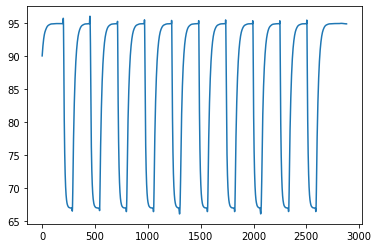

In [47]:
plt.plot(sol.t,sol.y[0])

In [ ]:
A,b = consMatrix(n_s,tf_ph,max_melt)
A.dot(opt_switch)[-2:], max_melt

In [ ]:
consMatrix(5,340,8)

# Test penality constrained optimization

In [ ]:
opt = opt_switch
inf = 0.
for k in range(n_s):
    period_length = opt[n_s + k] - opt[k];
    if (period_length <= 0):
        inf = inf - period_length;
        
for k in range(n_s-1):
    period_length = opt[k + 1] - opt[n_s + k];
    if (period_length <= 0):
        inf = inf - period_length;
        
inf

In [ ]:
tank.get_p_optimize

In [ ]:
tank.set_jacobian(p_optimize+1)

In [ ]:
tank.get_jacobian()

In [ ]:
wwtp.solve()

In [ ]:
p_opt = np.array(wwtp.get_p_optimize_ipopt())
p_opt = np.array([ 447.44352599,  499.75322923,  550.2893267 ,  602.63856181,
        630.47848751,  676.65375805,  723.65413866,  772.78485685,
        806.54718998,  847.94025342,  878.31043451,  905.9972652 ,
        943.04493388,  982.37840779, 1025.17521823, 1068.10743612,
       1111.56649538, 1154.57287817, 1183.78911905, 1199.05906347,
       1216.51849934, 1243.20067567, 1268.10618973, 1331.30419878,
       1850.42890297, 2028.97130226, 2130.89822784, 2220.31403264,
       2317.35466658, 2730.93899823,  459.24647286,  509.4085807 ,
        559.45260239,  610.50414002,  638.9197658 ,  687.67157256,
        736.16889124,  772.79674369,  819.41565582,  859.57862713,
        885.36434134,  918.8300471 ,  956.43230433,  997.16157838,
       1042.79630762, 1086.08410155, 1128.90232082, 1170.99081689,
       1187.32379257, 1199.6965982 , 1234.57743386, 1243.21783158,
       1284.87678999, 1357.44359503, 1976.62158129, 2077.50371712,
       2175.90916207, 2269.21311771, 2680.01794677, 2781.90372591])
p_opt

In [ ]:
x0 = np.array([90])
T = np.linspace(0,tf_ph,1000)
T_ode, X_ode, Z_ode = sol_ivp_wrapper(m1,x0,p_opt,tf_ph,T)

In [ ]:
p_opt[:n_s]/60,p_opt[n_s:]/60

In [ ]:
T_ode

In [ ]:
fig = plt.figure(figsize=(18,7))    
ax = fig.add_subplot(111)
ax.plot(T_ode,Z_ode[0],label = "capacity (%)")
ax.plot(T_ode,smooth_dap(T_ode,future_price) ,color='b', label = "Spot price * 60")
ax.plot(T_ode,smooth_regime(T_ode,p_opt) * 60 ,color='r', label = "Regime")
#ax.plot(p_opt[:n_s],np.array([np.min(Z_ode[0]) for i in range(n_s)]),'bo',label = 'MELT',alpha = 0.5)
#ax.plot(p_opt[n_s:],np.array([np.min(Z_ode[0]) for i in range(n_s)]),'r*',label = 'IDLE',alpha = 0.5)
ax.set_xticks(np.arange(0,future_price.size+1,5)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,future_price.size+1,5) * 60.])
ax.grid()
ax.legend()

In [ ]:
max_melt = 16*60
A,b = consMatrix(n_s,tf_ph,max_melt)

In [ ]:
A.dot(p_opt)[-2:], max_melt

In [ ]:
model = m1; x0 = np.array([90])
model = m2; x0 = np.array([2.6659426, 899.8884004])

start_date = '01-01-2013'
n_days = 2
dt = 0.01
seed = 1234
save_to_file = 1
nswitches = 10
history = simulate_MPC(model,x0,n_days,nswitches,prices,k,k_MELT,k_IDLE,dt,start_date,seed,save_to_file) 

In [ ]:
day = 0
plt.plot(history['T'][0],history['Z'][day])
plt.plot(history['T'][0],history['Z_ode'][day])
plt.grid()

In [ ]:
plt.plot(range(n_days),np.cumsum(history['expected_price']))
plt.plot(range(n_days),np.cumsum(history['true_price']))
plt.grid()

In [ ]:
history['expected_price'] - history['true_price']

In [ ]:
N = 10000
x = (np.random.rand(N) < 0.5).astype(np.float32)
plt.hist(x, 2)

In [ ]:
x

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
tHalf = 5700
lambd = np.log(2)/tHalf
N0 = 100
N = 0
# For 100 points
t = np.zeros(100)
for i in range(1, 100):
    N = i
    t[i] = (-1/lambd)*np.log(N/N0)

# For 1000 points
t2 = np.zeros(1000)
for i in range(1, 1000):
    N = i/10
    t2[i] = (-1/lambd)*np.log(N/N0)
        
plt.title("Carbon 14 decay") # Set the title of the graph 
plt.xlabel("Percent of Carbon 14 remaining") # Set the x-axis label
plt.ylabel("Age of material") # Set the y-axis label
# Change accordingly to number of points
plt.xlim([0, 100]) 
plt.ylim([0, 60000])
plt.plot(np.linspace(0,100,100)[1:],t[t>0])
plt.plot(np.linspace(0,100,1000)[1:],t2[t2>0])

In [ ]:
t2